# Portfolio Optimization 
### Analysis using Sharpe Ratio

1. Dependencies + Data collection (from Yfinance)

In [284]:
import os
from dotenv import load_dotenv
from fredapi import Fred # type: ignore
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta 
import numpy as np 
from scipy.optimize import minimize

load_dotenv()

True

In [285]:
tickers = ['GOOGL', 'QQQ', 'PG', 'VTI', 'AAPL'] # Arbitrary portfolio
base_ticker = 'SPY'

In [286]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365) # 5 years data 

In [287]:
adj_close_df = pd.DataFrame()
adj_close_df_test = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Adj Close']

data = yf.download(base_ticker, start=start_date, end=end_date)
adj_close_df_test[base_ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


2. Data cleaning - Calculate Lognormal Returns + Covariance Matrix

In [288]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()
print(log_returns)

log_returns_test = np.log(adj_close_df_test / adj_close_df_test.shift(1))
log_returns_test = log_returns_test.dropna()

cov_matrix = log_returns.cov()*252 # To annualize the daily returns
print(cov_matrix)

               GOOGL       QQQ        PG       VTI      AAPL
Date                                                        
2019-08-26  0.015142  0.014991  0.016904  0.010065  0.018821
2019-08-27 -0.000307 -0.002112  0.010256 -0.004643 -0.011348
2019-08-28  0.002499  0.003572  0.007026  0.007093  0.006688
2019-08-29  0.017306  0.015174 -0.001814  0.013166  0.016790
2019-08-30 -0.003111 -0.002397 -0.007870 -0.000336 -0.001293
...              ...       ...       ...       ...       ...
2024-08-14 -0.023358  0.000324  0.008986  0.002841  0.002032
2024-08-15  0.005782  0.024949 -0.005227  0.017173  0.013440
2024-08-16  0.010239  0.001285 -0.000179  0.002382  0.005901
2024-08-19  0.022511  0.013050  0.003152  0.009400 -0.000708
2024-08-20  0.003055 -0.002101  0.011746 -0.002433  0.002741

[1255 rows x 5 columns]
          GOOGL       QQQ        PG       VTI      AAPL
GOOGL  0.102266  0.065930  0.023520  0.051364  0.067391
QQQ    0.065930  0.065024  0.024306  0.050941  0.068635
PG     0.02352

3. Calculating Portfolio Standard Deviation

In [289]:
def standard_deviation (weights, cov_maxtric):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

4. Calculating Expected return

In [290]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

5. Calculating Sharpe Ratio


In [291]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate)

6. Setting Risk-Free Rate

In [292]:
fredapi_key = os.getenv("FREDAPI_KEY")

fred = Fred(api_key = fredapi_key)
ten_year_tresury_rate = fred.get_series_latest_release('GS10') / 100

# Setting the rate
risk_free_rate = ten_year_tresury_rate.iloc[-1]
print(risk_free_rate)


0.0425


7. Setting contraints and bounds

In [293]:
# Basically weigts should add up to 1 
contraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# Min bound 0 i.e. cannot short any security
# Max bound 0.5 i.e. cannot allocate more than 50% to 1 security
bounds = [(0, 0.5) for _ in range(len(tickers))]

# Initial weights set to equal
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


8. Optimize weights to maximize Sharpe Ratio 

In [294]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=contraints, bounds=bounds)
optimal_weights = optimized_results.x

9. Results

In [295]:
print('Optimal Weights:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f'{ticker}: {weight:.4f}')

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print()

print(f'Optimal Portfolio Return: {optimal_portfolio_return:.4f}')
print(f'Optimal Portfolio Volatility: {optimal_portfolio_volatility:.4f}')
print(f'Optimal Sharpe Ratio: {optimal_sharpe_ratio:.4f}')

Optimal Weights:
GOOGL: 0.1309
QQQ: 0.2632
PG: 0.1059
VTI: 0.0000
AAPL: 0.5000

Optimal Portfolio Return: 0.2452
Optimal Portfolio Volatility: 0.2615
Optimal Sharpe Ratio: 0.7752


10. Plotting some Data

<function matplotlib.pyplot.show(close=None, block=None)>

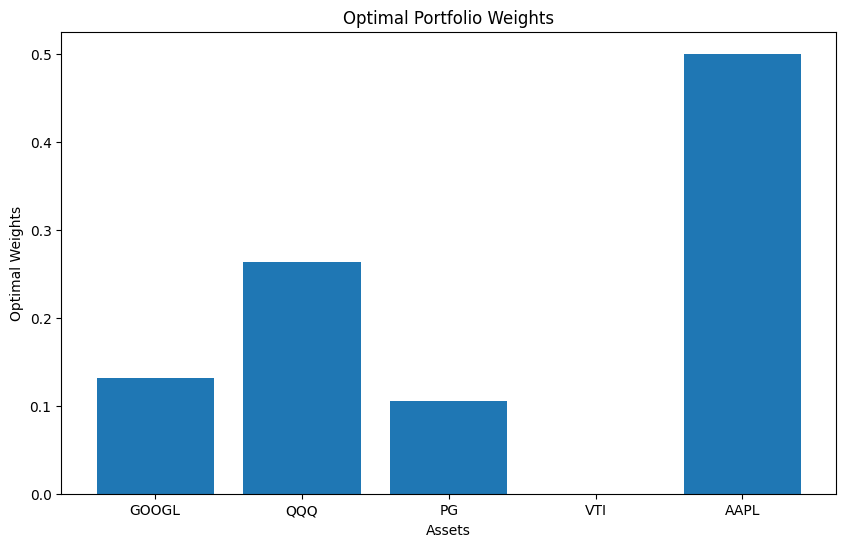

In [296]:
import matplotlib.pyplot as plt # type: ignore

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show

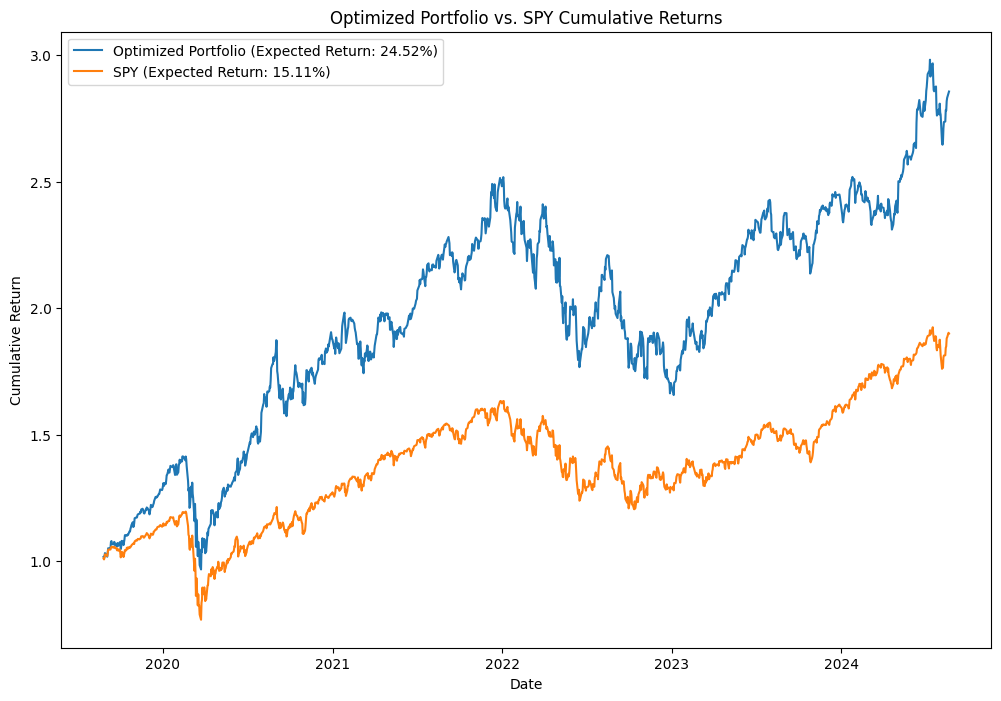

Expected Return of Optimized Portfolio: 0.2452
Expected Return of SPY: 0.1511


In [297]:
# Calculate cumulative returns for the optimized portfolio
optimal_portfolio_daily_returns = (log_returns * optimal_weights).sum(axis=1)
optimal_portfolio_cumulative_returns = (1 + optimal_portfolio_daily_returns).cumprod()

# Calculate cumulative returns for SPY
spy_cumulative_returns = (1 + log_returns_test[base_ticker]).cumprod()

# Calculate expected returns
spy_expected_return = expected_return([1], log_returns_test)

# Align dates for plotting
aligned_returns = pd.concat([optimal_portfolio_cumulative_returns, spy_cumulative_returns], axis=1)
aligned_returns.columns = ['Optimized Portfolio', base_ticker]

# Plotting the cumulative returns
import matplotlib.pyplot as plt # type: ignore

plt.figure(figsize=(12, 8))
plt.plot(aligned_returns.index, aligned_returns['Optimized Portfolio'], label=f'Optimized Portfolio (Expected Return: {optimal_portfolio_return:.2%})')
plt.plot(aligned_returns.index, aligned_returns[base_ticker], label=f'{base_ticker} (Expected Return: {spy_expected_return:.2%})')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Optimized Portfolio vs. SPY Cumulative Returns')
plt.legend()
plt.show()

print(f'Expected Return of Optimized Portfolio: {optimal_portfolio_return:.4f}')
print(f'Expected Return of SPY: {spy_expected_return:.4f}')

if (spy_expected_return > optimal_portfolio_return):
    print('LMAO, SPY still won 🤣')